In [ ]:
from warnings import filterwarnings

In [ ]:
filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.graphics.tsaplots as sgt
from sklearn import preprocessing
from matplotlib import pyplot as plt

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_sber = pd.read_csv("/content/drive/My Drive/final_sber/SBER_000101_230827.csv", index_col=["DATE"], parse_dates={'DATE':["<DATE>", '<TIME>']}, sep=';')


## Предварительный анализ и предобработка данных

In [ ]:
data_sber.info()

In [ ]:
data = data_sber.copy()
data.tail()

,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
DATE,,,,,
2023-08-21,262.33,263.06,259.51,261.15,35622200
2023-08-22,261.90,262.11,259.81,261.45,25893210
2023-08-23,261.55,261.83,256.00,256.40,53079140
2023-08-24,257.62,259.94,256.40,259.63,26823420
2023-08-25,258.80,261.60,257.61,260.50,28518670


In [ ]:
# переименование названий столбцов
data = data.rename(columns=             #переименование
             {'<DATE>':'DATE',
              '<OPEN>':'OPEN',
              '<HIGH>':'HIGH',
              '<LOW>':'LOW',
              '<CLOSE>':'CLOSE',
              '<VOL>':'VOL'
              })


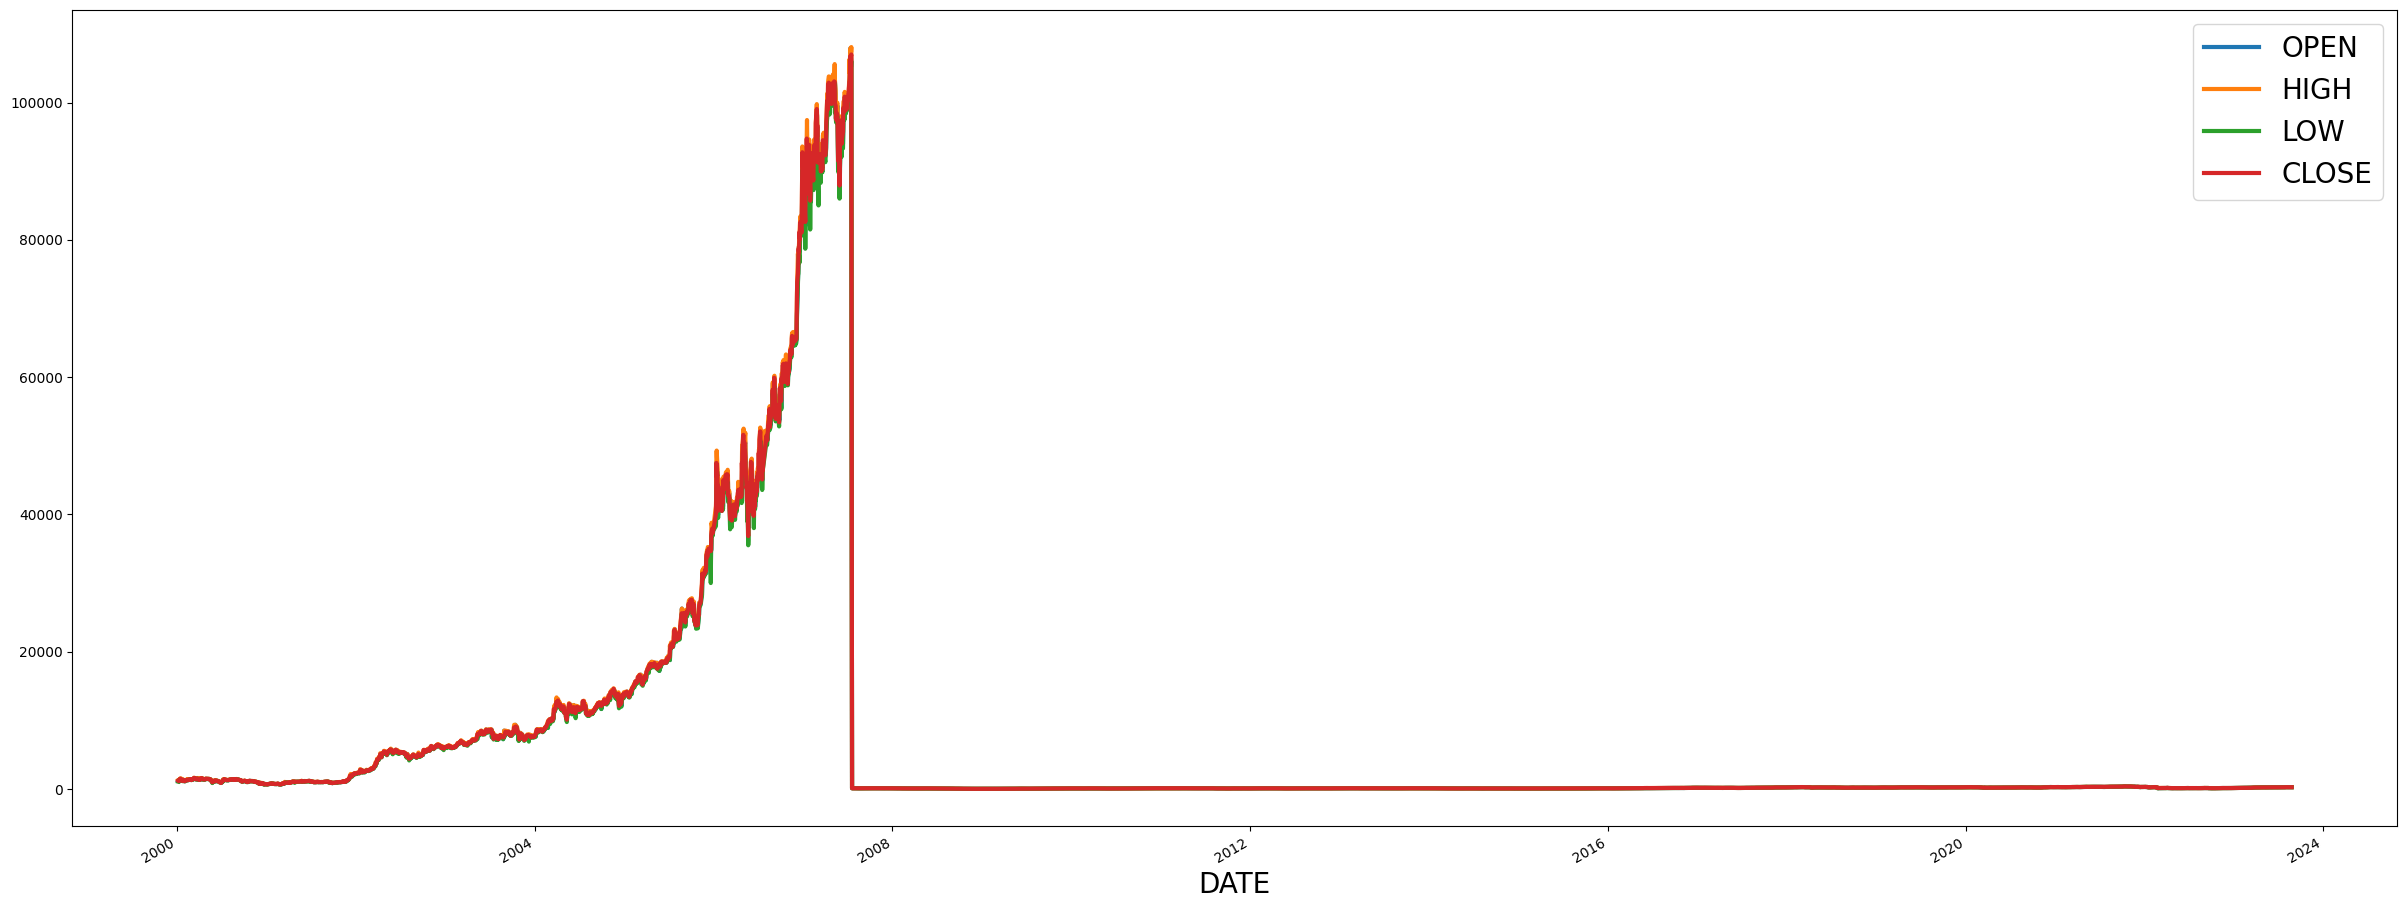

In [ ]:
#  График изменения цены акций

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.drop('VOL', axis=1).plot()
plt.show()

*Вывод: 18 июля 2007 года было дробление акций и цена упала с 107000 до 109,2 рублей*

In [ ]:
# интерполяция, заполняем пропущенные дни, выходные и праздничные
data = data.resample('D').interpolate(method='linear')

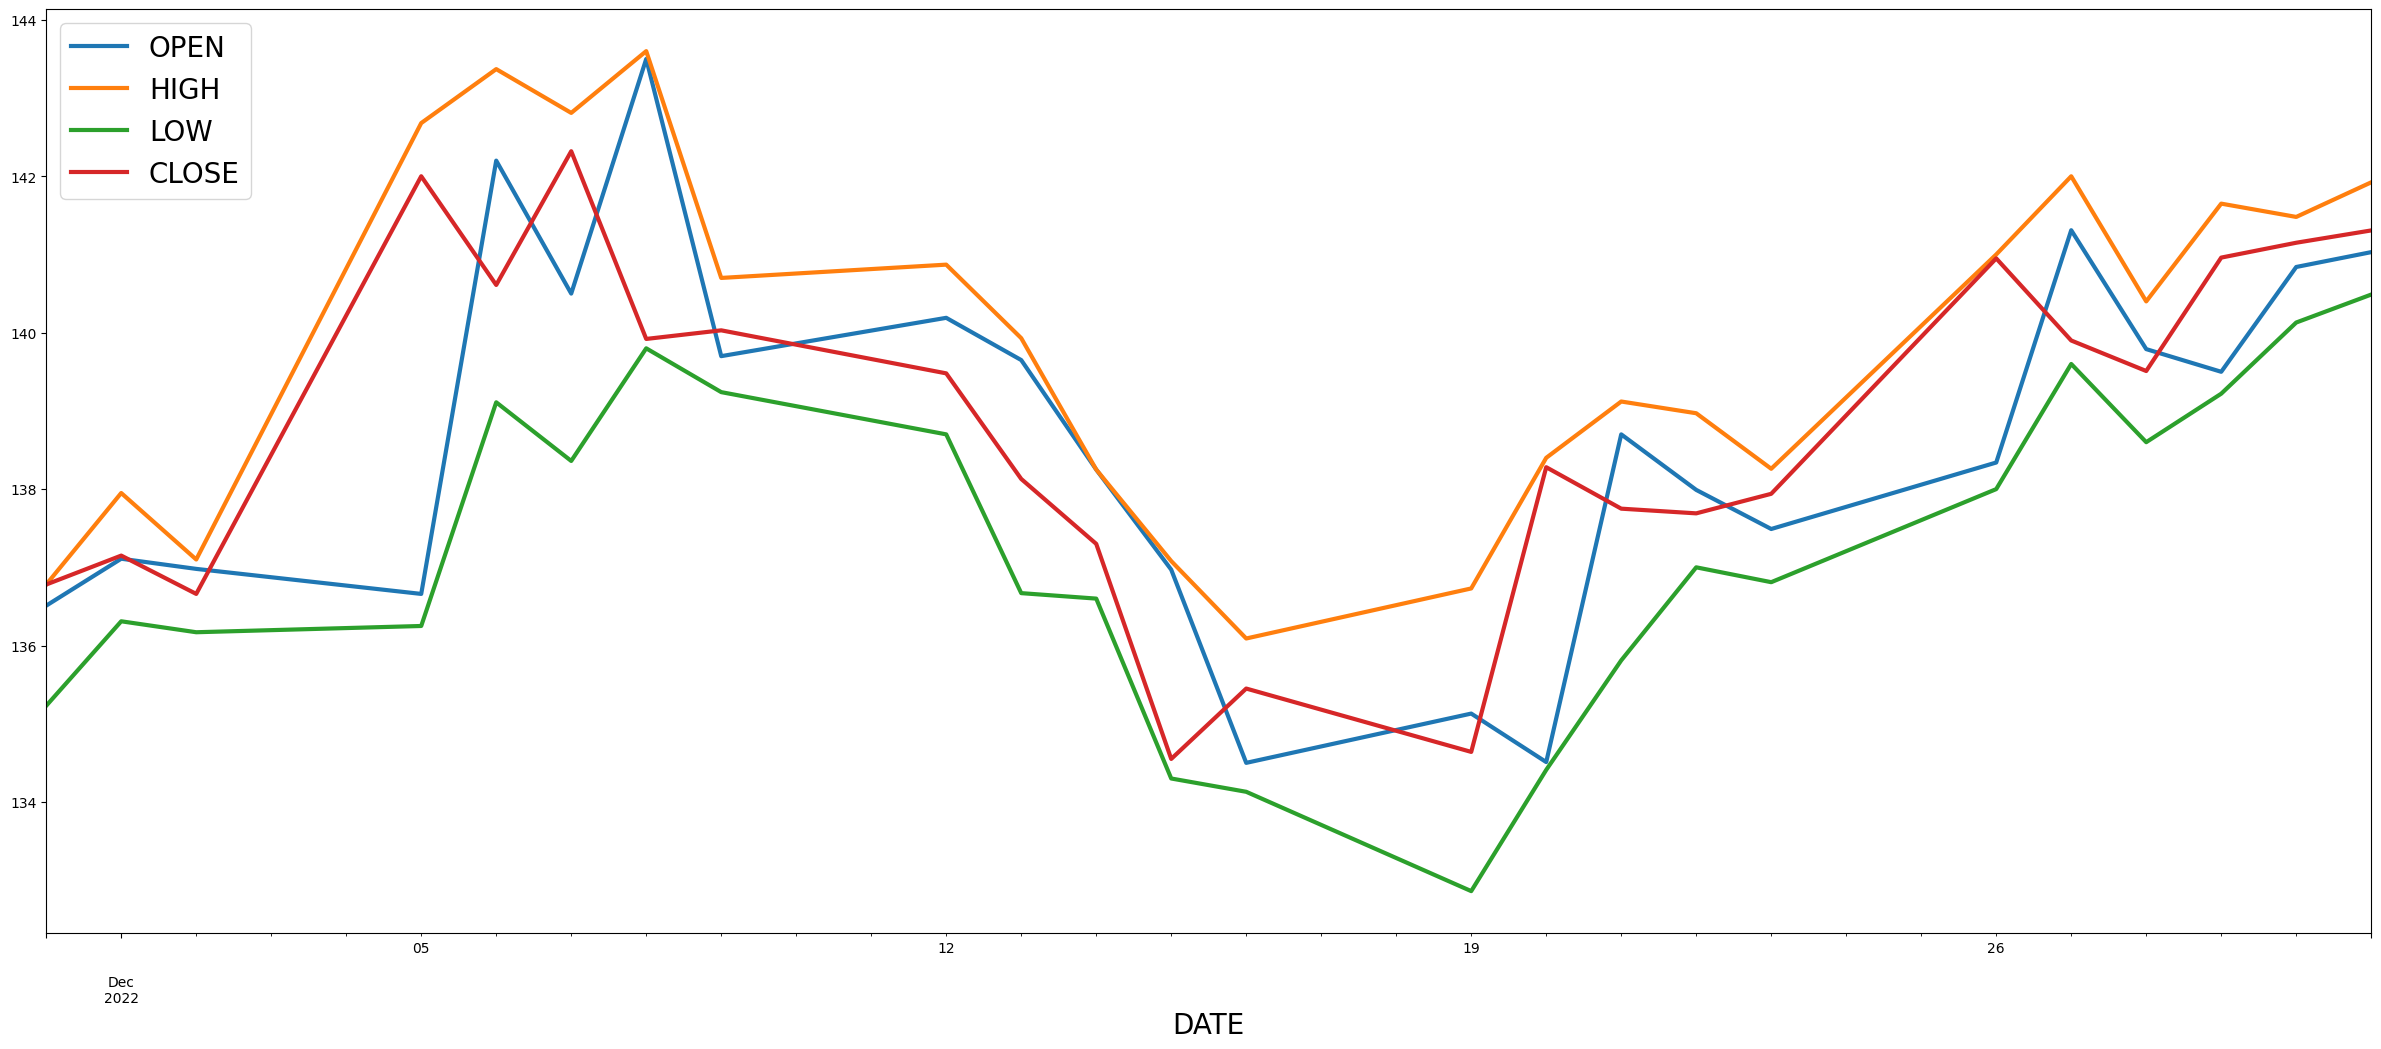

In [ ]:
# Для наглядности рассмотрим данные за один месяц

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data["2022-11-30":"2022-12-31"].drop('VOL', axis=1).plot()
plt.show()

In [ ]:
#в качестве экзогенных данных, возьмем прошлые данные за один день
data_exog = data.shift(1).dropna()

In [ ]:
#Возьмем временной ряд начиная с дробления акций
# Отложим три года из датасета как тестовую выборку для оценки результатов предсказания
train_start, train_end = '2008-01-01', '2019-12-31'
test_start, test_end = '2020-01-01', '2022-12-31'
train_df = data.loc[train_start:train_end]
test_df = data.loc[test_start:test_end]

# для экзогенных данных
train_df_exog = data_exog.loc[train_start:train_end]
test_df_exog = data_exog.loc[test_start:test_end]
train_df.shape, test_df.shape, train_df_exog.shape, test_df_exog.shape

((4383, 5), (1096, 5), (4383, 5), (1096, 5))

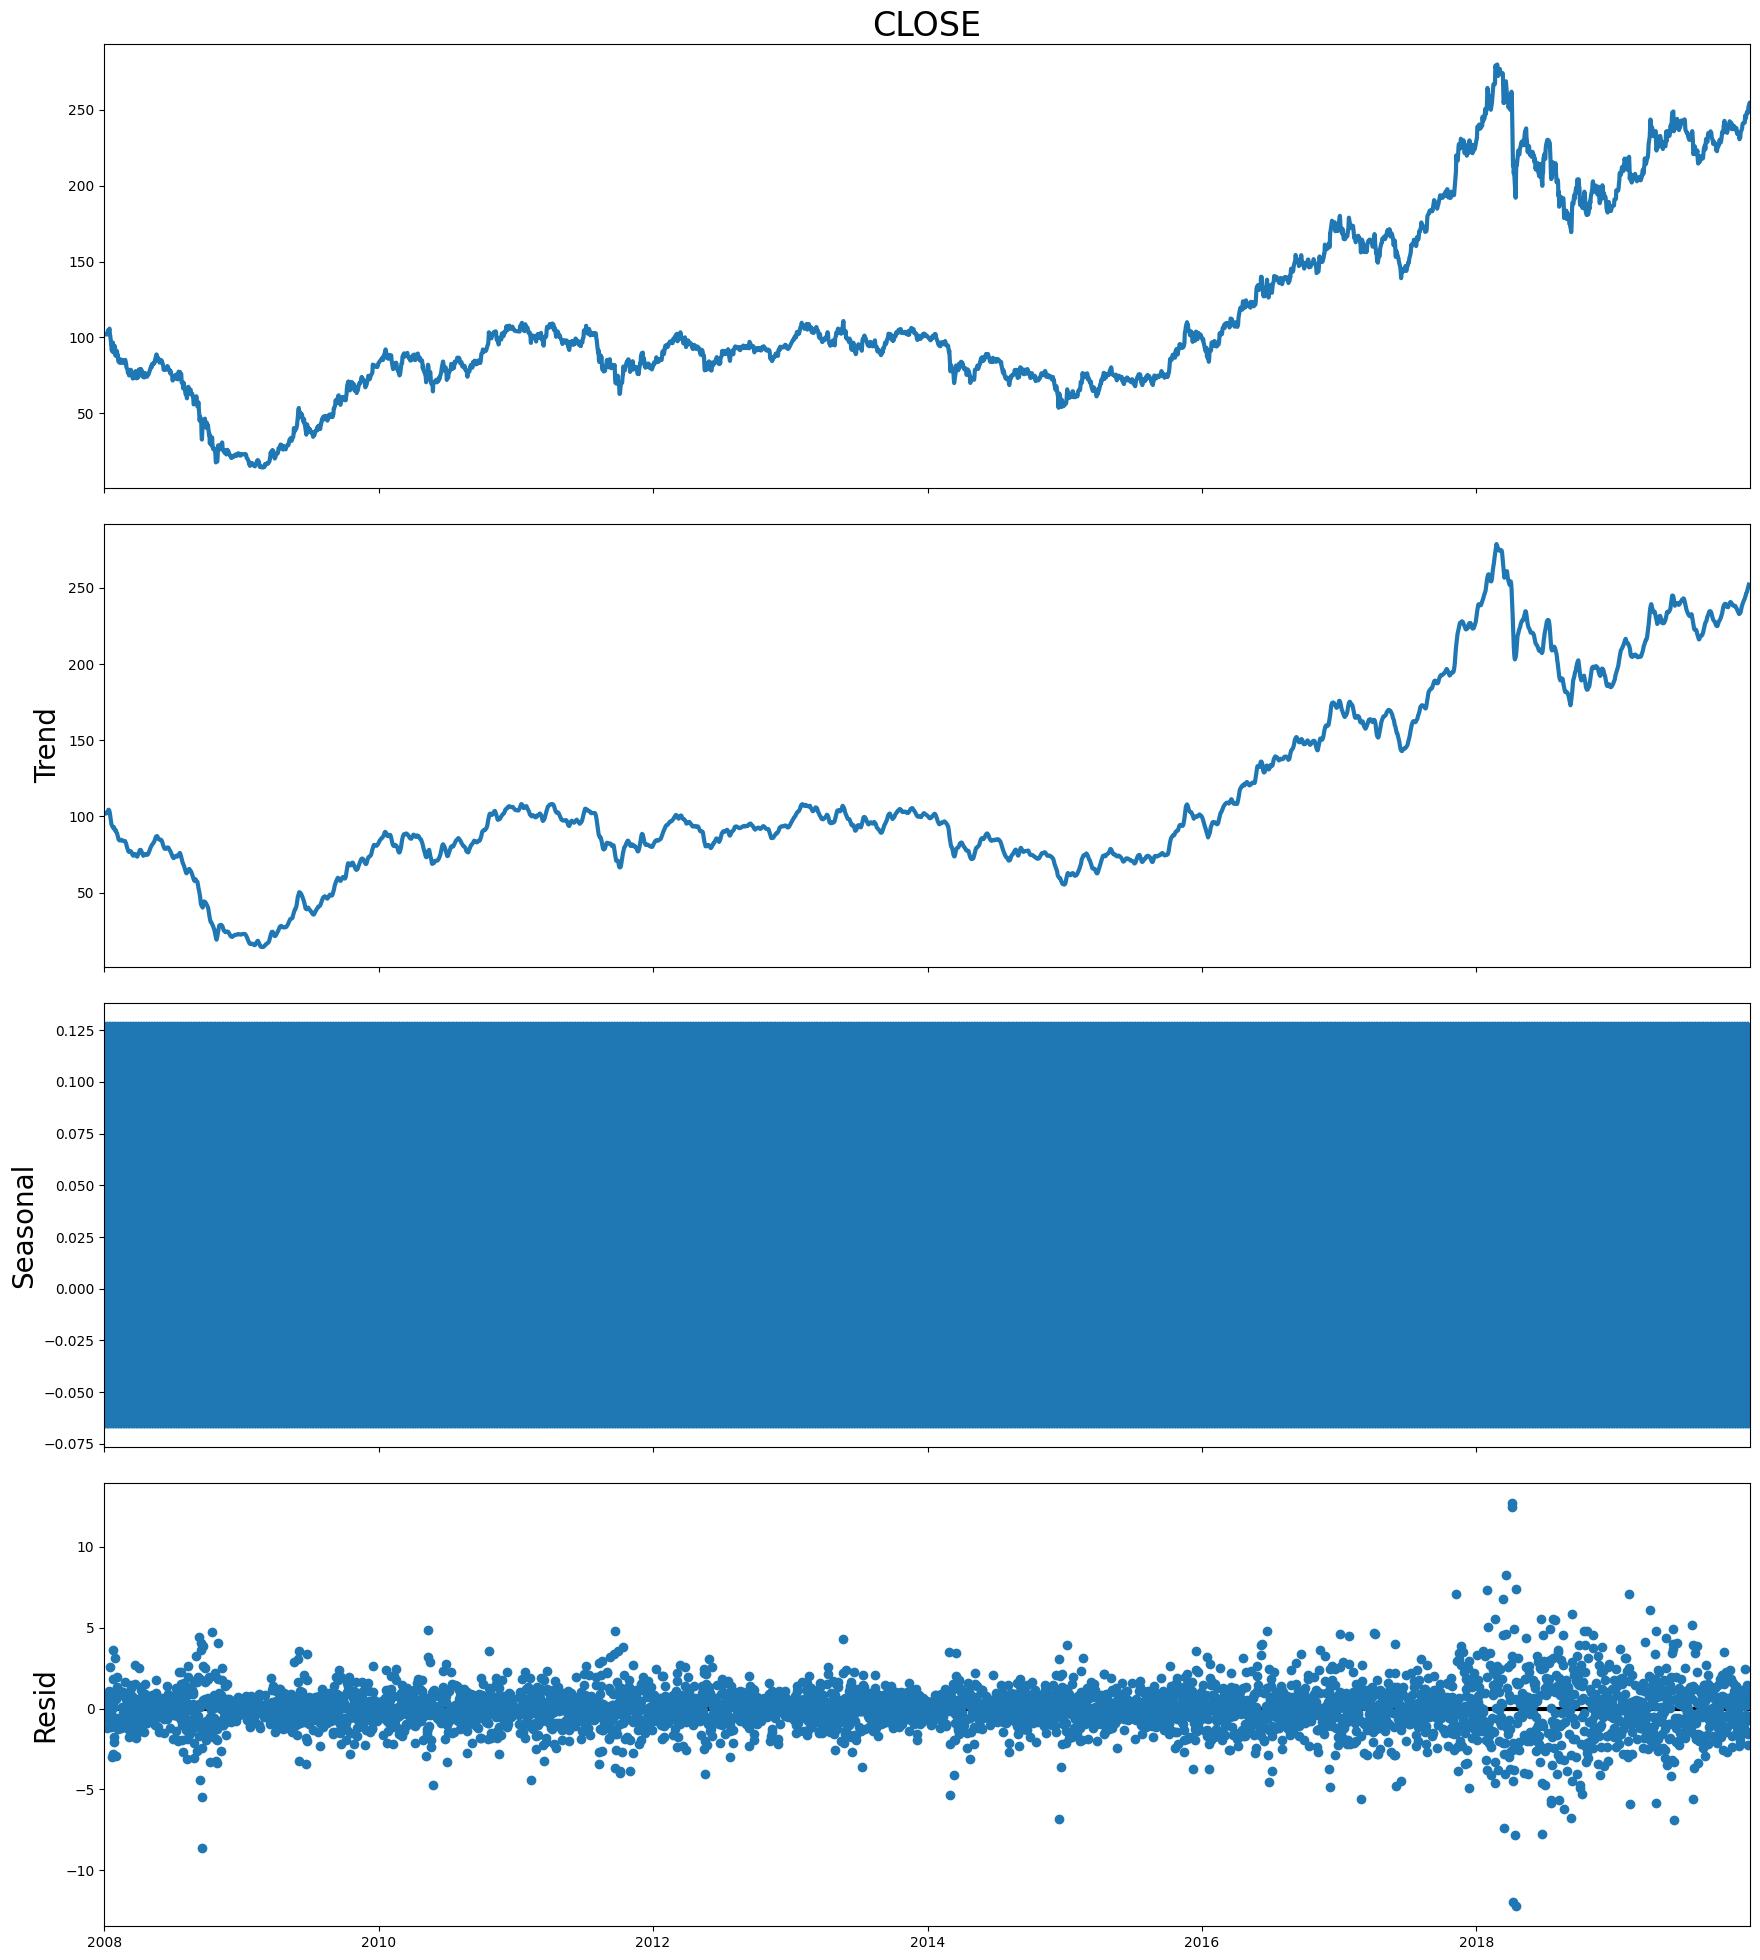

In [ ]:
# # Проанализируем временной ряд на наличие тренда и сезонности
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['CLOSE'] )
result.plot()
plt.show()

*Вывод: За весь период виден слабый восходящий тренд. Хотя есть некоторые перепады тренда на более меньших промежутках времени. Сезонная компонента присутствует. Также наблюдается шум с некоторыми всплесками*

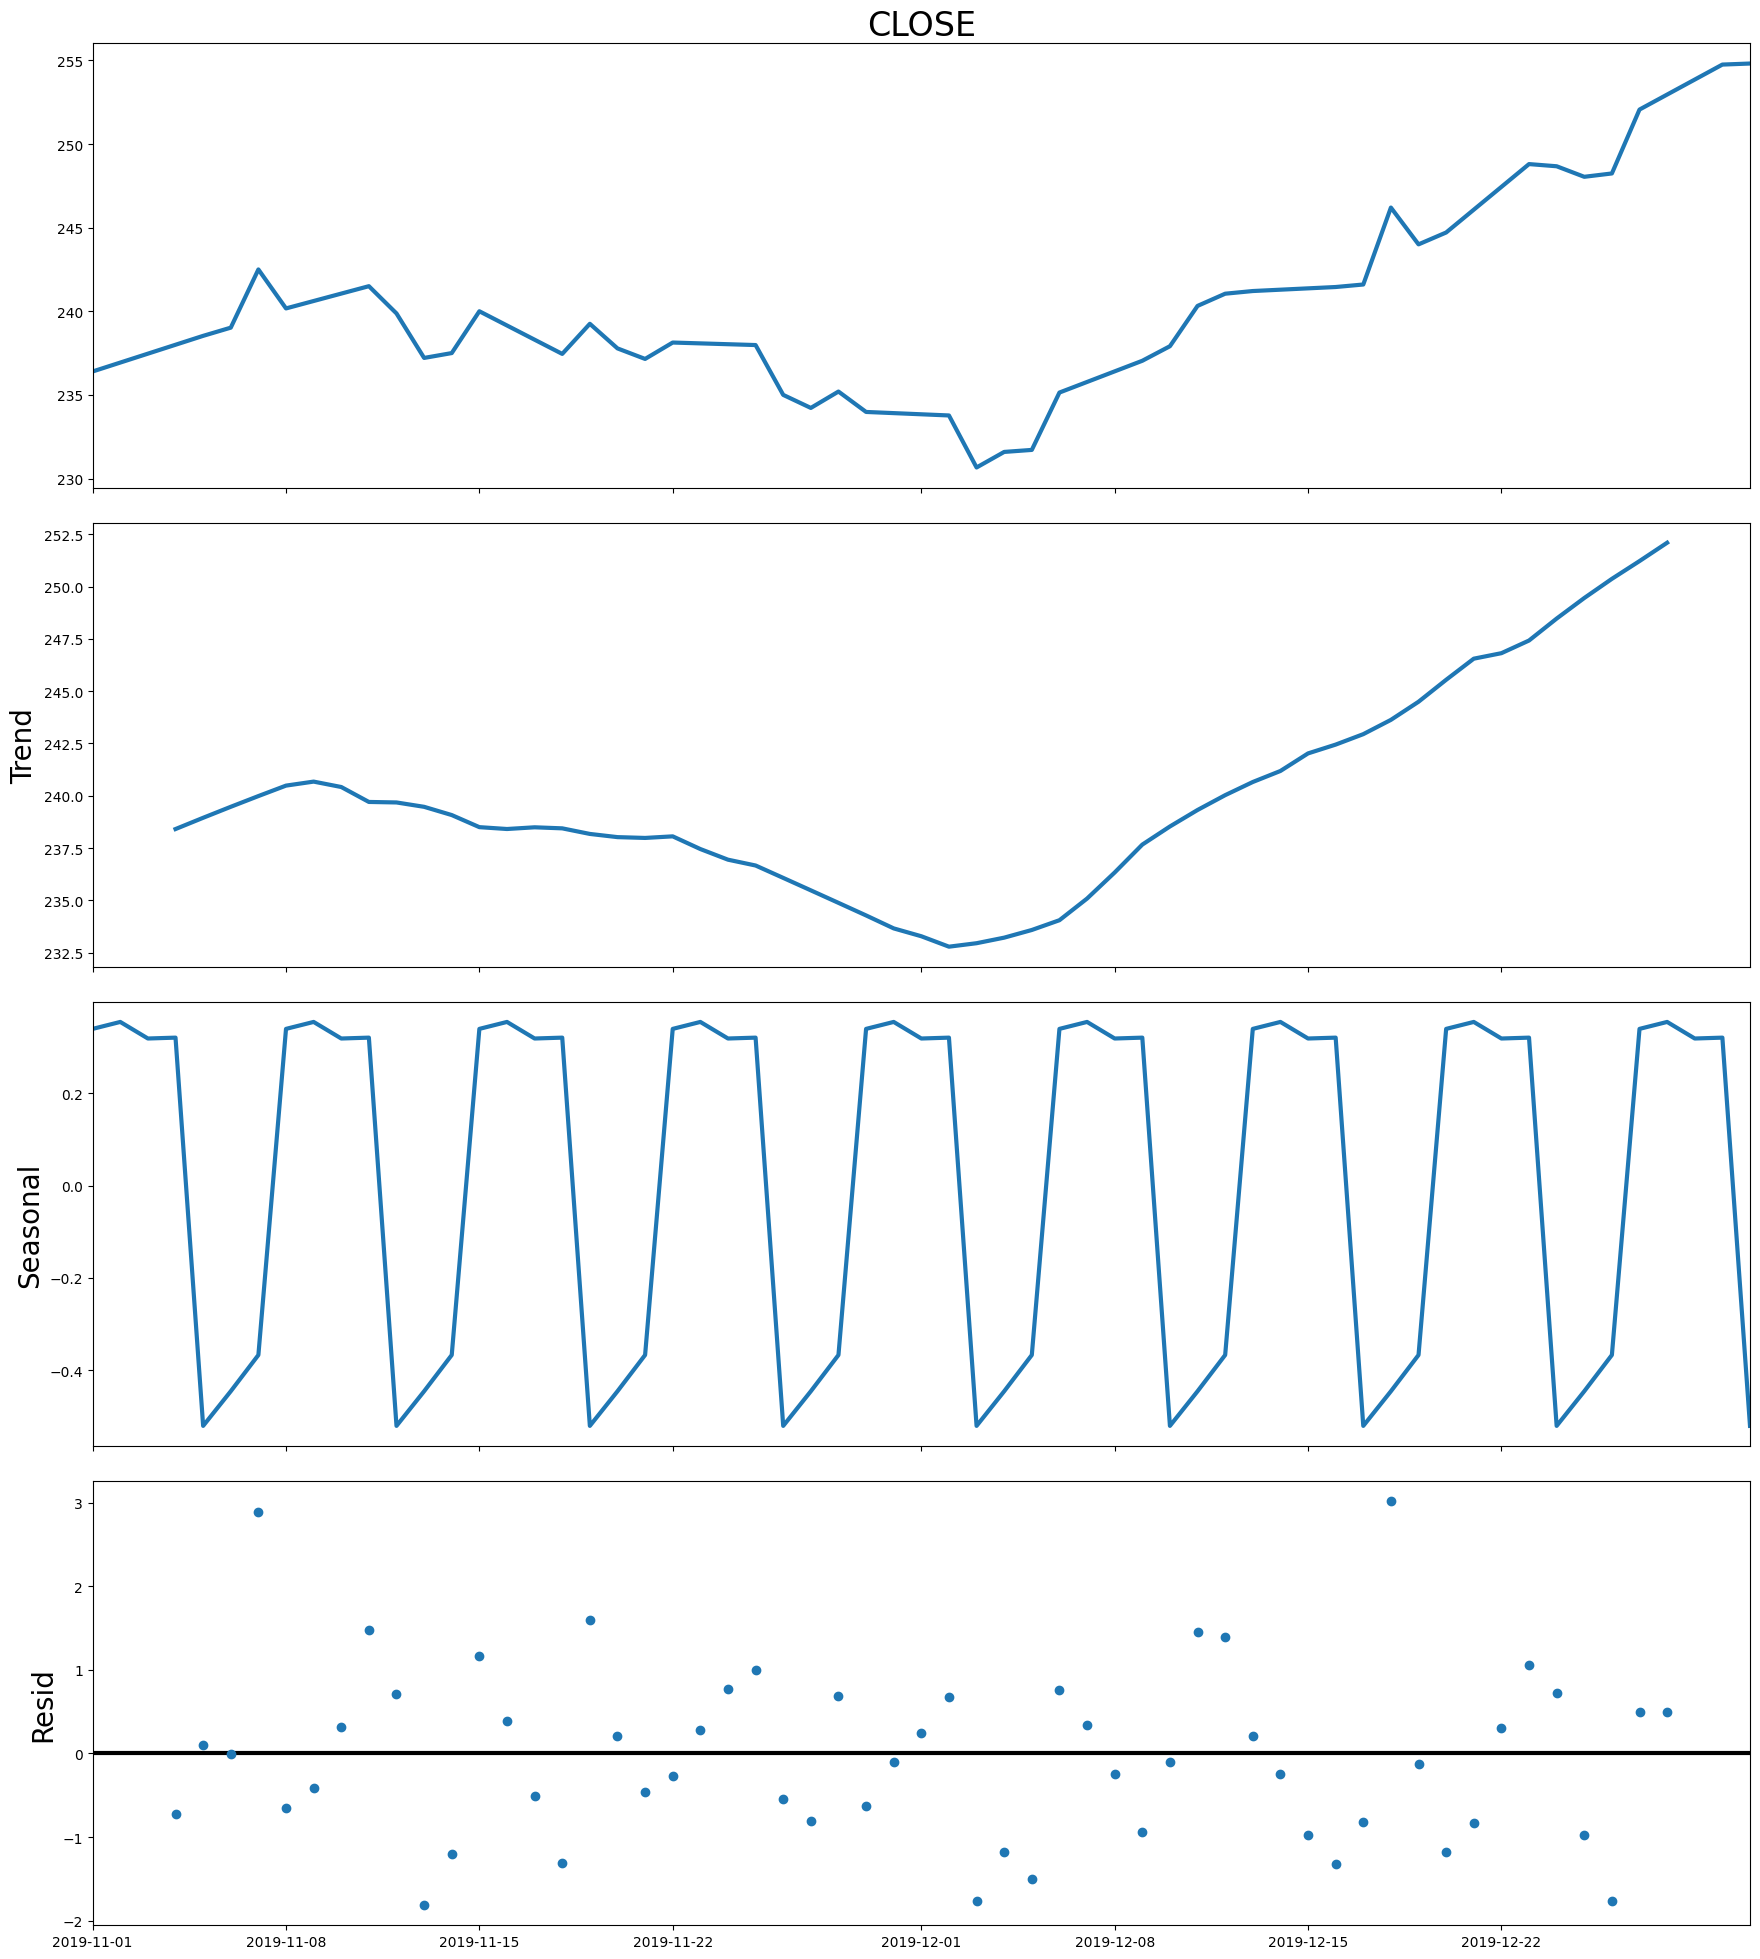

In [ ]:
# Проанализируем временной ряд на наличие тренда и сезонности на двух месяцах
# анализ проводится на коротком промежутке, чтобы увидеть сезонность

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['CLOSE'].loc["2019-11-01":] )
result.plot()
plt.show()

*Вывод: Направление тренда меняется со временем. Есть сезонность в 7 дней. Наблюдается шум.*

##Автокорреляция

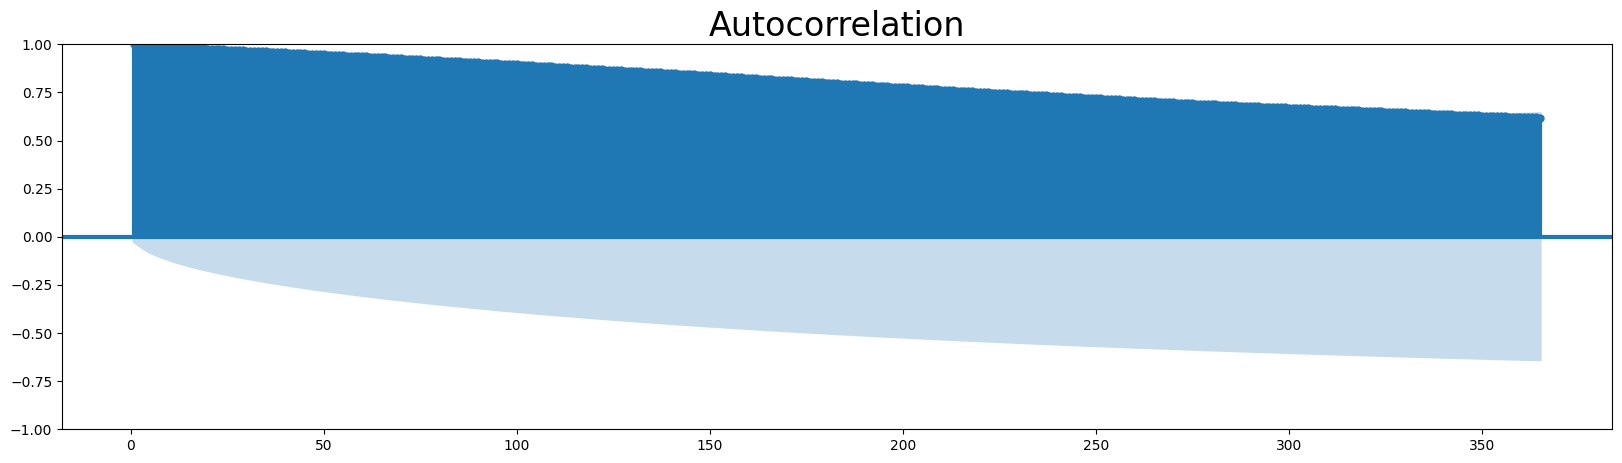

In [ ]:
# Автокорреляция
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df['CLOSE'], lags=365, zero=False)
plt.show()

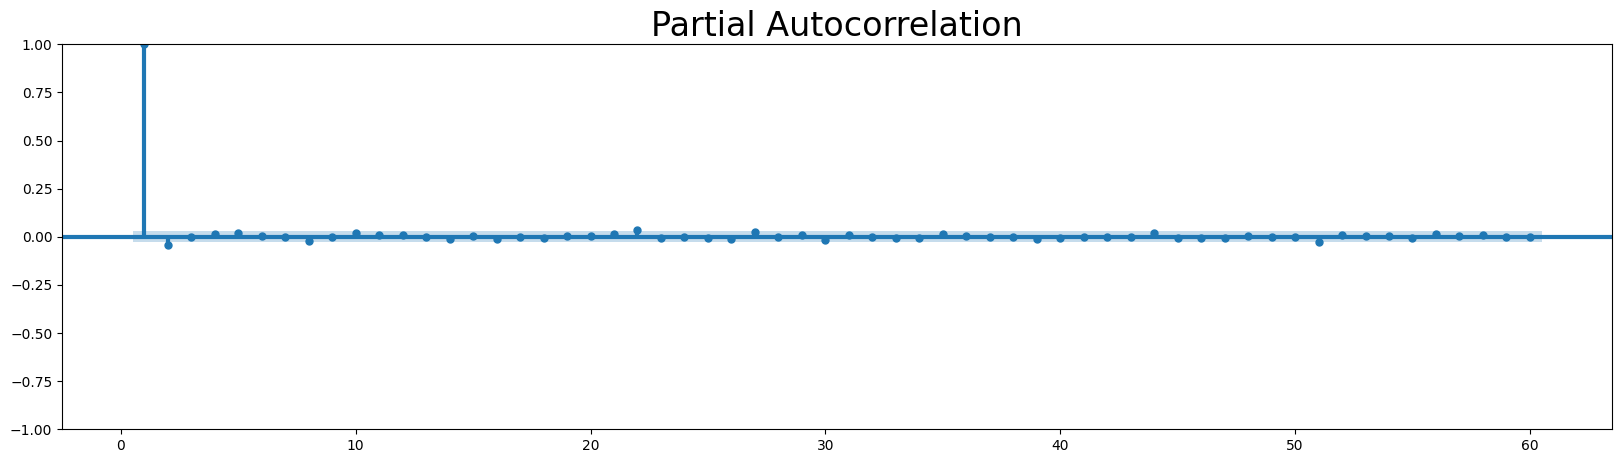

In [ ]:
# Частичная автокорреляция
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df['CLOSE'], lags=60, method="ywm", zero=False)
plt.show()

In [ ]:

from statsmodels.tsa.stattools import adfuller
# функция теста
def stat_test(df):
    test = adfuller(df, regression='ctt')
    print ('adf: ', test[0] )
    print ('p-value: ', test[1])
    print('Critical values: ', test[4])
    if (test[0]> test[4]['5%']):
        print ('ряд не стационарен')
    else:
        print ('ряд стационарен')

# первый тест Дики-Фуллера
from statsmodels.tsa.stattools import adfuller

stat_test(train_df['CLOSE'])


adf:  -2.422811420483663
p-value:  0.613058558942842
Critical values:  {'1%': -4.373789122001291, '5%': -3.83374486591183, '10%': -3.5540994444059706}
ряд не стационарен


*Вывод: Значения цен хорошо коррелируются в течении года. Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.
Значения цен не являются стационарными, поэтому невозможно сделать какие-нибудь выводы*

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

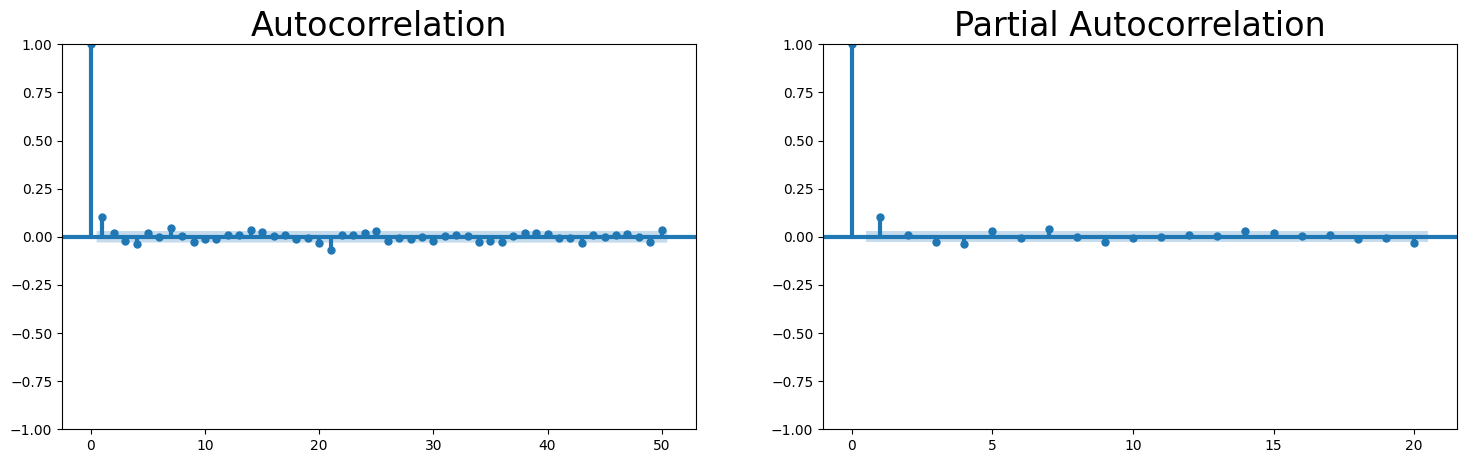

adf:  -15.299431284026067
p-value:  4.014749463238725e-24
Critical values:  {'1%': -4.373789122001291, '5%': -3.83374486591183, '10%': -3.5540994444059706}
ряд стационарен


In [ ]:
# функция вывода графика корреляций
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=50)
    sgt.plot_pacf(series, ax=axes[1], lags=20, method="ywm")
    plt.show()

# дифференцирование первого порядка
plot_acf_pacf(train_df["CLOSE"].diff(periods=1).dropna())
stat_test(train_df["CLOSE"].diff().dropna())

*Вывод: порядок дифференцирования d=1, значение теста меньше всех критический значений. Из частичной автокорреляции можно определить p=1, а q=1 по коррелограме*

## Обучение модели

## ARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1
- d = 1
- q = 1


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df['CLOSE'],
                    order=(1, 1, 1),
                    enforce_stationarity=False,
                    enforce_invertibility=False)
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  CLOSE   No. Observations:                 4383
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8839.929
Date:                Sun, 10 Sep 2023   AIC                          17685.857
Time:                        07:22:39   BIC                          17705.011
Sample:                    01-01-2008   HQIC                         17692.616
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1515      0.081      1.860      0.063      -0.008       0.311
ma.L1         -0.0479      0.084     -0.572      0.567      -0.212       0.116
sigma2         3.3155      0.032    104.147      0.000       3.253       3.378
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             13099.39
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

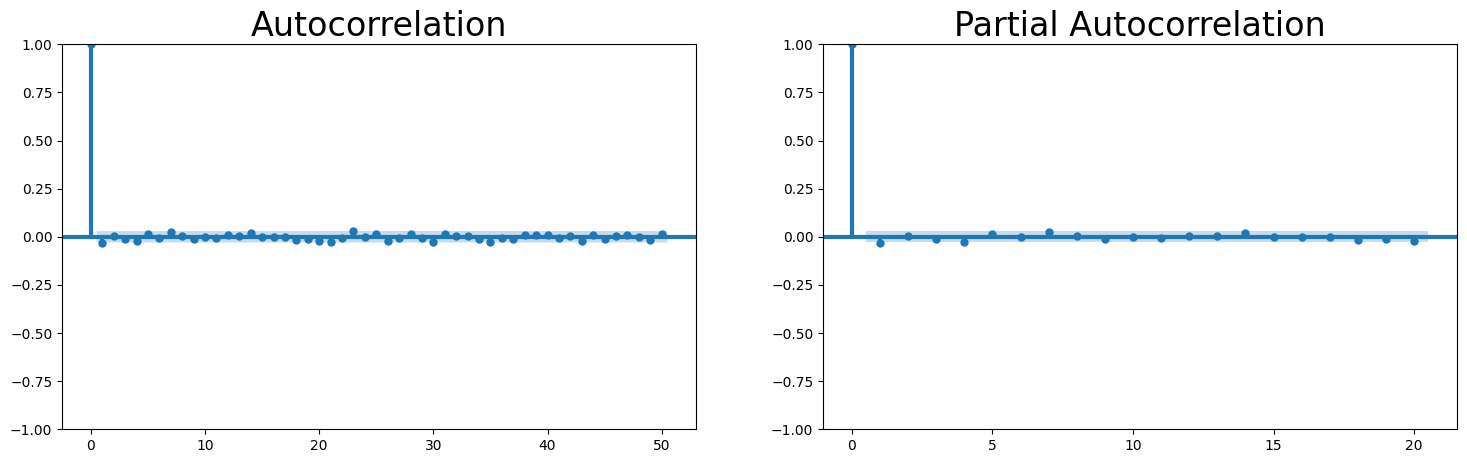

In [ ]:
res = arima_model_fit.resid

plot_acf_pacf(res)

*Ошибки этой модели имеют мало автокорреляции.*

In [ ]:
from sklearn.metrics import mean_squared_error
pred = arima_model_fit.predict(test_start, test_end)
print('ARIMA model MSE:{}'.format(mean_squared_error(test_df['CLOSE'].values, pred)))

ARIMA model MSE:6324.924299753007


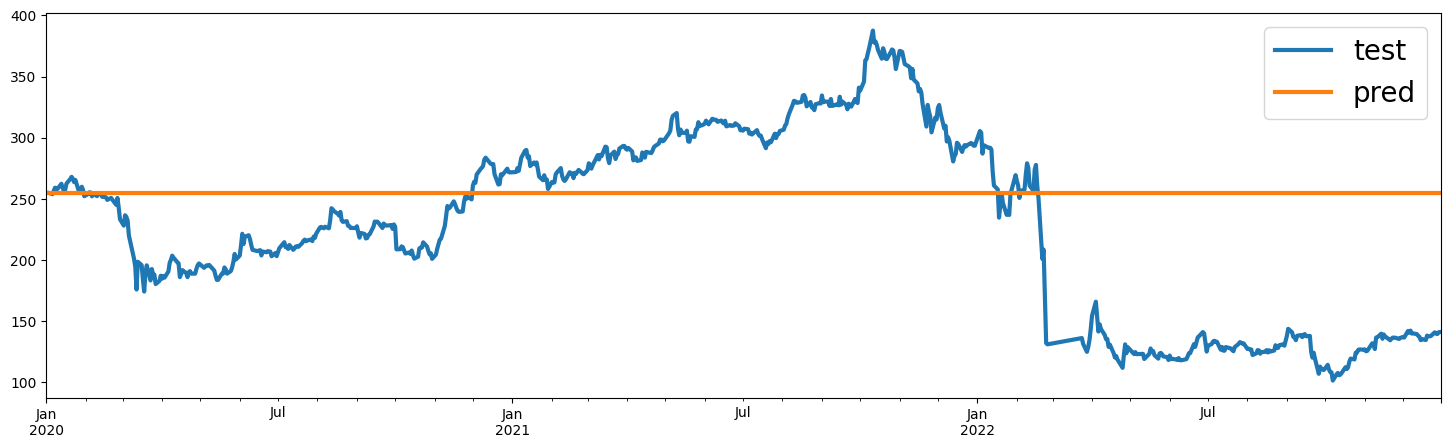

In [ ]:
# График истинных и предсказанных значений
pd.DataFrame({'test':test_df['CLOSE'].values,'pred':pred}).plot();plt.show()

*Вывод: Видим, что модель не смогла предсказать колебания цен*

## SARIMAX

In [ ]:
# Подберем наилучшие параметры для SARIMAX с помощью пакета pmdarima
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.8 MB/s eta 0:00:00


In [ ]:
# логарифмуем данные, чтобы привести к гомоскедастичности
train_exog_log = np.log(train_df_exog)
train_df_log = np.log(train_df["CLOSE"].dropna())

In [ ]:
# Оценка сезонного разностного члена, D для SARIMAX
from pmdarima.arima.utils import nsdiffs

# оценить количество сезонных различий с помощью теста Кановы-Хансена
D = nsdiffs(train_df_log,
            m=7,
            max_D=12,
            test='ch')

print('D = ', D)

D =  0


In [ ]:
# подберём наилучшие параметры с помощью пакета pmdarima
import pmdarima as pm

smodel = pm.auto_arima(
    train_df_log,
    train_exog_log,
    start_p=1,
    max_p=3,
    d=1,
    max_d=1,
    start_q=1,
    max_q=3,
    D=0,
    max_order=8,
    start_P=1,
    start_Q=1,
    m=7,
    test="adf",
    error_action="ignore",
    trace=True,
    seasonal=True,
    n_jobs=-1
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-21540.357, Time=12.22 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-21547.537, Time=2.77 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-21545.665, Time=9.39 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-21545.752, Time=5.96 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=-21549.155, Time=4.46 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-21547.669, Time=12.68 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-21547.756, Time=15.42 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-21544.548, Time=16.28 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-21545.541, Time=4.21 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-21545.541, Time=10.13 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-21543.527, Time=10.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7]          
Total fit time: 103.882 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4383
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10780.578
Date:                Sun, 10 Sep 2023   AIC                         -21549.155
Time:                        07:28:54   BIC                         -21510.844
Sample:                    01-01-2008   HQIC                        -21535.637
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OPEN           0.0889      0.014      6.559      0.000       0.062       0.115
HIGH          -0.1558      0.017     -9.192      0.000      -0.189      -0.123
LOW           -0.0553      0.012     -4.783      0.000      -0.078      -0.033
CLOSE          0.2003      0.013     15.169      0.000       0.174       0.226
VOL           -0.0011      0.001     -0.969      0.333      -0.003       0.001
sigma2         0.0004   2.71e-06    157.657      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            117471.37
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Вывод: Best model:  SARIMAX(p=0, d=1, q=0)(P=0, D=0, Q=0)[m=7]*

In [ ]:
# обучение модели на лучших параметрах pmdarima

pmdarima_model = ARIMA(train_df_log,
                       train_exog_log,
                       order=(0, 1, 0),
                       seasonal_order=(0, 0, 0, 7),
                       enforce_stationarity=False,
                       enforce_invertibility=False)

pmdarima_model_fit = pmdarima_model.fit()
pmdarima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  CLOSE   No. Observations:                 4383
Model:                 ARIMA(0, 1, 0)   Log Likelihood               10777.617
Date:                Sun, 10 Sep 2023   AIC                         -21543.235
Time:                        07:29:38   BIC                         -21504.925
Sample:                    01-01-2008   HQIC                        -21529.717
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OPEN           0.0889      0.014      6.557      0.000       0.062       0.115
HIGH          -0.1558      0.017     -9.190      0.000      -0.189      -0.123
LOW           -0.0553      0.012     -4.782      0.000      -0.078      -0.033
CLOSE          0.2003      0.013     15.165      0.000       0.174       0.226
VOL           -0.0011      0.001     -0.969      0.333      -0.003       0.001
sigma2         0.0004   2.71e-06    157.622      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            117384.67
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        28.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

*Вывод:  Лучшая модель - это модель SARIMAX с параметрами, найденные с помощью pmdarima. AIC = -21543.235.*

##Прогноз

In [ ]:
# создание датафрейм для предсказания scale
pred_df = pd.DataFrame(index=data[train_start:test_end].index)


# логарифмуем данные, чтобы привести к гомоскедастичности
test_exog_log = np.log(test_df_exog)

# прогноз на моделе pmdarima_model_fit, с лучшими параметрами
pred_df["model_preds"] = np.exp(pmdarima_model_fit.predict(
    start=test_start, end=test_end, dynamic=True,
    exog = test_exog_log,
))

# записываем в датафрейм истинные значения
pred_df["CLOSE"] = data["CLOSE"][train_start:test_end]
# доверительные интервалы
forecast = pmdarima_model_fit.get_forecast(len(test_df.index), exog = test_exog_log)
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = np.exp(forecast_df["lower CLOSE"])
pred_df.at[test_df.index, "model_preds_upper"] = np.exp(forecast_df["upper CLOSE"])


# Ошибки
from sklearn.metrics import mean_squared_error
y_true = pred_df['CLOSE'].loc[test_start:]
y_pred = pred_df['model_preds'].loc[test_start:]
mse = mean_squared_error(y_true, y_pred, squared=False)
rmse = mean_squared_error(y_true, y_pred, squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 71.511475 
RMSE = 5113.891072


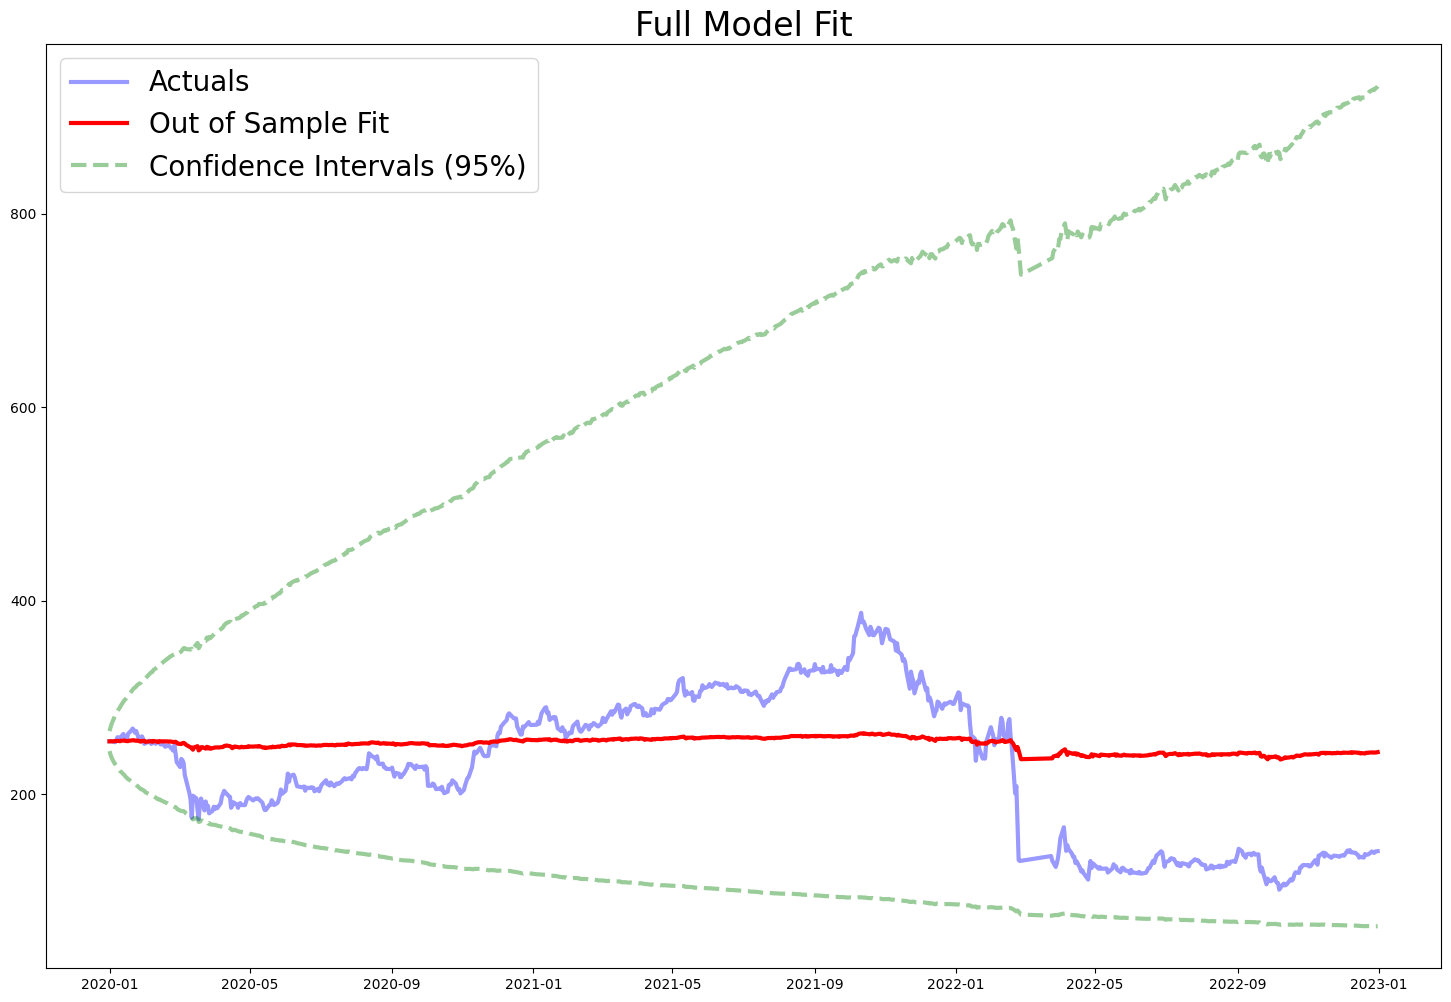

In [ ]:
# график предсказанных значений с доверительными интервалами на истинных значениях
plt.rcParams["figure.figsize"] = 18, 12

#plt.subplot(2, 1, 1)
plt.plot(pred_df.loc['2020-01-01':]["CLOSE"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()
plt.show()

*Вывод: AIC SARIMAX больше, чем ARIMA. Видим, что модель предсказывает колебания цен, но ни всю амплитуду.*

## Одномерные сверточные слои

In [ ]:
import os
import tarfile
from six.moves import urllib

import seaborn as sns
from sklearn.metrics import roc_curve, auc
from graphviz import Source
from IPython.display import display

import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import Flatten, Dropout, Embedding


In [ ]:
data1 = data_sber['2008-01-01':]

В качестве обучающих данных будем применять значения признаков 'OPEN'-цена открытия сессиии, 'HIGH'- высшая цена, 'LOW'-низкая цена за сессию. Также будем использовать трендовую линию Bollinger Bands, часто используемых трейдерами. Он формируются из цен акций "CLOSE".

In [ ]:
# фиксируем seed
np.random.seed(7)

# функция переименования столбцов
def renameCOL(df):

  df = df.rename(columns=
   {'<OPEN>':'OPEN',
    '<HIGH>':'HIGH',
    '<LOW>':'LOW',
    '<CLOSE>':'CLOSE',
    '<VOL>':'VOL'})
  return (df)

# функция расчета трендовой линии болинджер бандс
def bolingerB(BB_period, df):
    n = 2
    df['BBs'] = df.CLOSE.rolling(BB_period).mean()
    df['BBdn'] = (df.CLOSE-df.BBs) ** 2
    df['BBup'] = df.BBs + n * np.sqrt(df.BBdn.rolling(BB_period).sum() / BB_period)
    df['BBdn'] = df.BBs - n * np.sqrt(df.BBdn.rolling(BB_period).sum() / BB_period)
    return (df)

BB_period = 55 # значение перида, для расчета трендовой линии болинджер бандс

(data1) = renameCOL(data1)
data = bolingerB(BB_period, data1)

data = data1.drop(['VOL'], axis=1) #удаление столбцов
data = data.fillna(0)
data = data[109:].copy() # отбрасываем нулевые значения по BBs, BBdn, BBup
#Заполняем текстовые названия каналов данных
chanelNames = list(data.columns)


In [ ]:
data.head()

,OPEN,HIGH,LOW,CLOSE,BBs,BBdn,BBup
DATE,,,,,,,
2008-06-17,79.49,81.46,79.27,81.05,79.806909,68.339041,91.274777
2008-06-18,80.67,81.79,80.24,80.65,79.932364,68.887983,90.976744
2008-06-19,80.00,80.75,79.66,80.22,80.054909,69.431123,90.678695
2008-06-20,80.20,80.75,78.50,79.00,80.125818,69.780906,90.470730
2008-06-23,78.46,79.00,77.50,78.09,80.113818,69.839493,90.388144


Text(0, 0.5, 'SBER rate')

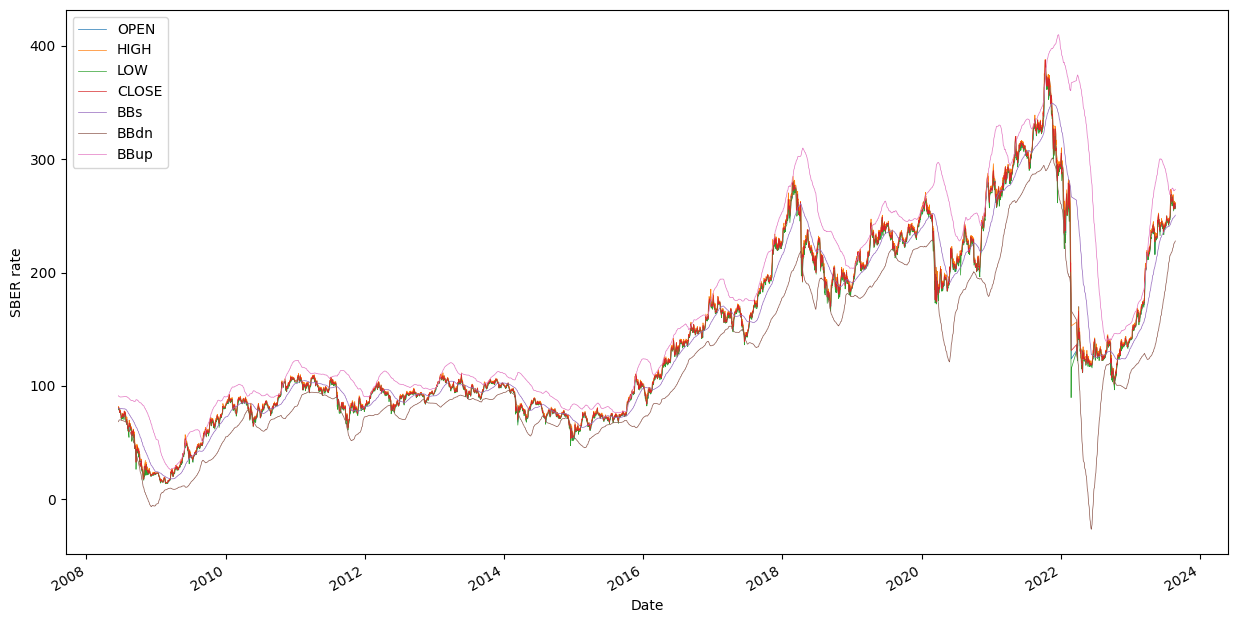

In [ ]:
# Отрисуем временной ряд:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
data.plot(ax=ax, lw=.5)
ax.set_title('График цен Сбера с 01.01.2008г.', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('SBER rate')

Text(0, 0.5, 'SBER rate')

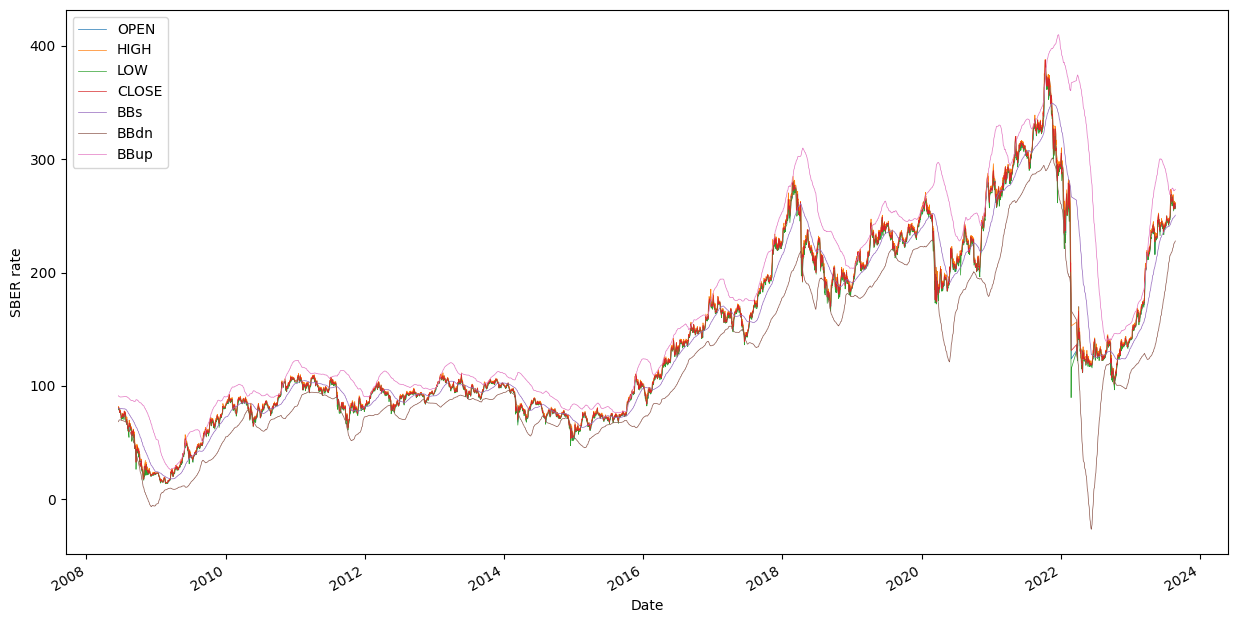

In [ ]:
# Отрисуем временной ряд за короткий промежуток для наглядности:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
data.loc['2023-06-01':].plot(ax=ax, lw=.5)
ax.set_title('График цен Сбера с 01.06.2023г.', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('SBER rate')

*Вывод: BBs - это MA на 55 шагах, BBup и BBdn - это в основном верхняя и нижняя граница колебания цен. Хотя при быстром скачке цены могут выйти за эти границы.*

In [ ]:
# Отделяем тестовую часть данных, 20%.
data_test = data[round(data.shape[0] * 0.8):].copy()
data = data[:round(data.shape[0] * 0.8)].copy()
print(data.shape)
print(data_test.shape)

(3040, 7)
(760, 7)


In [ ]:
# Функция нормализации данных
#Normalization = 0 - StandardScaler, 1 - MinMaxScaler, 2 - RobustScaler, -1 - не нормализовывать
def DataNormalization(datan, Channels, Normalization):
  #Выбираем тип нормализации x

  if (Normalization == 0):
    scaler = StandardScaler()
  if (Normalization == 1):
    scaler = MinMaxScaler()
  if (Normalization == 2):
    scaler = RobustScaler()

    #Берём только те каналы, которые указаны в аргументе функции
  resData = datan[:,Channels]
  if (len(resData.shape) == 1): #Если размерность входного массива - одномерный вектор,
    print("Add one dimension")
    resData = np.expand_dims(resData, axis=1) #то добавляем размерность

  if (Normalization == -1):
    scaler = np.zeros(resData.shape[0])
    return (resData, scaler)

  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

In [ ]:
#Теперь сама функция по «раскусыванию» временного ряда для подготовки к передаче на сверточную сеть:

#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер "окна", по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее, если 1 - то на 1 шаг
#xNormalization - нормализация входных каналов
#yNormalization - нормализация прогнозируемых каналов
#returnFlatten - True - если на выходе получить одномерный вектор для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)

def getTrainSeq(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization,
                returnFlatten, valLen):
  if isinstance(data,(pd.core.series.Series, pd.core.frame.DataFrame)): #Проверяем, если на входе Pandas - то, берем values, для получения numpy Array
    print("Convert Pandas.Series to Numpy array")
    data = data.values
  #Нормализуем данные
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)
  #Вычисляем сколько данных с конца нужно взять, чтобы размерность xVal/yVal была valLen
  valLen = valLen + xLen - 1 + stepsForward
  #Разбивка входного ряда до обработки на обучающую и валидационную
  xTrain = xData[:xData.shape[0] - valLen]
  yTrain = yData[:yData.shape[0] - valLen]
  xVal = xData[xData.shape[0] - valLen:]
  yVal = yData[yData.shape[0]-valLen:]
  # формирование трехмерной матрицы в 1-ой размерности лежит временной ряд,
  #2-ой - в нашем случае окно в 55 прошлых значений,
  #3-й - каналы, признаки по которым обучаемся. В нашем случае: RSI1, RSI2, BBs, BBup, BBdn
  # т.е. за шаг во временном ряду мы будем подавать на вход матрицу [55,5] - 55 прошлых значений 5 каналов(признаков)
  xTrain = np.array([xTrain[i:i + xLen] for i in range(xTrain.shape[0] - xLen + 1 - stepsForward)])   #, xChannels
  yTrain = np.array([yTrain[i:i + stepsForward] for i in range(xLen, yTrain.shape[0] + 1 - stepsForward)])
  xVal = np.array([xVal[i:i + xLen] for i in range(xVal.shape[0] - xLen + 1 - stepsForward)])  #, xChannels
  yVal = np.array([yVal[i:i + stepsForward] for i in range(xLen, yVal.shape[0] + 1 - stepsForward)])

  #Если в функцию передали вернуть flatten сигнал (для Dense сети), то xTrain и xVal превращаем в flatten
  if (returnFlatten == True):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])
  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [ ]:
#Протестируем работу функции на тестовом numpy.array:

xLen = 55 #Анализируем по 55 прошедшим точкам
stepsForward = 1            #Тренируем сеть для предсказания на 1 шагов вперед
xChannels = range(data.shape[1]) #Используем все входные каналы
yChannels = 3               #Предказываем только CLOSE канал
xNormalization = 2          #Нормируем входные каналы RobustScaler
yNormalization = 2          #Нормируем выходные каналы RobustScaler
valLen = round(data.shape[0] * 0.2)              #Используем 20% записей для проверки
returnFlatten = False       #Если True, то вернуть одномерные векторы, если False, то двумерные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getTrainSeq(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen)

#Выводим размеры данных
print("xTrain.shape:", xTrain.shape)
print("yTrain.shape:", yTrain.shape)
print("xVal.shape:", xVal.shape)
print("yVal.shape:", yVal.shape)

Convert Pandas.Series to Numpy array
Add one dimension
xTrain.shape: (2322, 55, 7)
yTrain.shape: (2322, 1, 1)
xVal.shape: (608, 55, 7)
yVal.shape: (608, 1, 1)


Epoch 1/50
73/73 [==============================] - 2s 20ms/step - loss: 0.0080 - val_loss: 0.0212
Epoch 2/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0057 - val_loss: 0.0174
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0049 - val_loss: 0.0138
Epoch 4/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0045 - val_loss: 0.0124
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 0.0042 - val_loss: 0.0111
Epoch 6/50
73/73 [==============================] - 2s 28ms/step - loss: 0.0040 - val_loss: 0.0107
Epoch 7/50
73/73 [==============================] - 2s 27ms/step - loss: 0.0039 - val_loss: 0.0098
Epoch 8/50
73/73 [==============================] - 1s 19ms/step - loss: 0.0038 - val_loss: 0.0095
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0037 - val_loss: 0.0095
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 0.0036 - val_loss: 0.0086
Epoch 11/

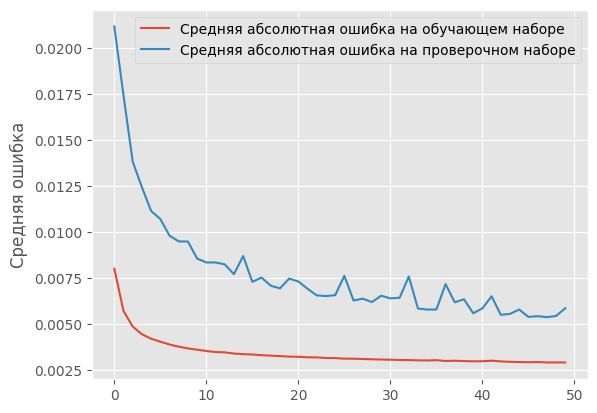

In [ ]:
#Сеть одномерной свертки
from keras.layers import Dense, Dropout

from keras.layers import Embedding

from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from tensorflow.keras import regularizers

model = Sequential()
model.add(Conv1D(55,
                 3,
                 padding='causal',
                 input_shape = (xTrain.shape[1], xTrain.shape[2]),
                 activation = "linear",
                 kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)))

model.add(Flatten())
model.add(Dense(275, activation = "linear"))
model.add(Dense(yTrain.shape[1], activation = "linear"))
model.compile(loss = "huber_loss", optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-6))

history = model.fit(xTrain, yTrain, epochs = 50, verbose = 1, validation_data = (xVal, yVal))

# Выводим график изменения ошибок
plt.plot(history.history['loss'],
label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()


In [ ]:
# разбивка тестовых данных
def func_test(data_test1, yChannels):

  data_test = data_test1.fillna(0)
  if isinstance(data_test,(pd.core.series.Series, pd.core.frame.DataFrame)):
    print("Convert Pandas.Series to Numpy array")
    data_test = data_test.values

  (xTest, xScaler) = DataNormalization(data_test, xChannels, xNormalization)
  (yTest, yScaler) = DataNormalization(data_test, yChannels, yNormalization)
  xTest = np.array([xTest[i:i + xLen] for i in range(xTest.shape[0] - xLen + 1 - stepsForward)])
  yTest = np.array([yTest[i:i + stepsForward] for i in range(xLen, yTest.shape[0] + 1 - stepsForward)])
  return (xTest, yTest, yScaler)

(xTest, yTest, yScaler) = func_test(data_test, yChannels)

#Выводим размеры данных
print("xTest.shape:", xTest.shape)
print("yTest.shape:", yTest.shape)
data_test.head()

Convert Pandas.Series to Numpy array
Add one dimension
xTest.shape: (705, 55, 7)
yTest.shape: (705, 1, 1)


,OPEN,HIGH,LOW,CLOSE,BBs,BBdn,BBup
DATE,,,,,,,
2020-08-03,222.27,228.36,221.30,226.72,207.806909,182.582722,233.031096
2020-08-04,227.39,228.85,225.63,227.16,208.595091,183.179270,234.010911
2020-08-05,228.15,229.17,224.31,226.40,209.368727,183.794461,234.942994
2020-08-06,226.60,227.43,224.35,226.00,210.042727,184.181178,235.904276
2020-08-07,225.05,227.60,224.46,227.28,210.738727,184.547284,236.930171


23/23 [==============================] - 0s 7ms/step


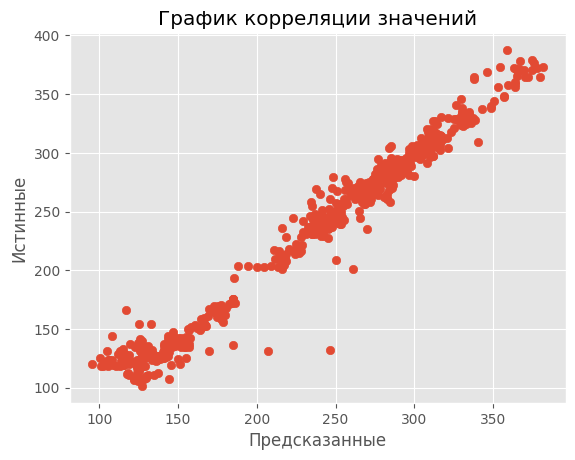

In [ ]:
#Визуализация результатов

#Функция рассчитывает результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(np.reshape(yVal,(yVal.shape[0], -1)))
  #yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)


#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel],
           label='Базовый ряд')

  plt.title("График цен предсказанного и базового ряда")
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()


#Прогнозируем данные текущей сетью
currModel = model
(predVal, yValUnscaled) = getPred(currModel, xTest, yTest, yScaler)

# график корреляции истинных и предсказанных значений
import matplotlib
matplotlib.style.use('ggplot')
plt.scatter(predVal, yValUnscaled)
plt.title("График корреляции значений")
plt.xlabel("Предсказанные")
plt.ylabel("Истинные")
plt.show()


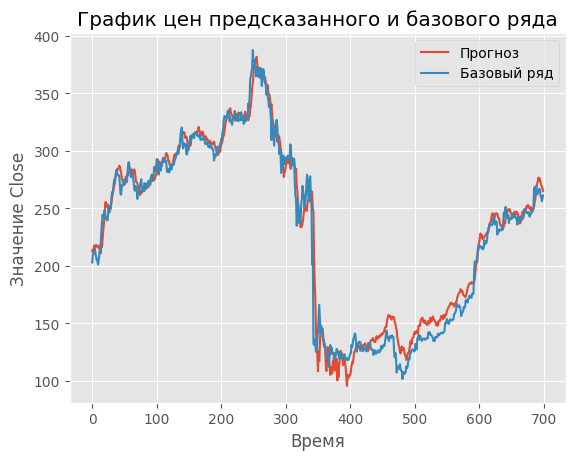

In [ ]:
#Отображаем график распределения прогнозируемого и базового ряда
# задаем начало и интервал отображения графика
showPredict(0, 700, 0, predVal, yValUnscaled)

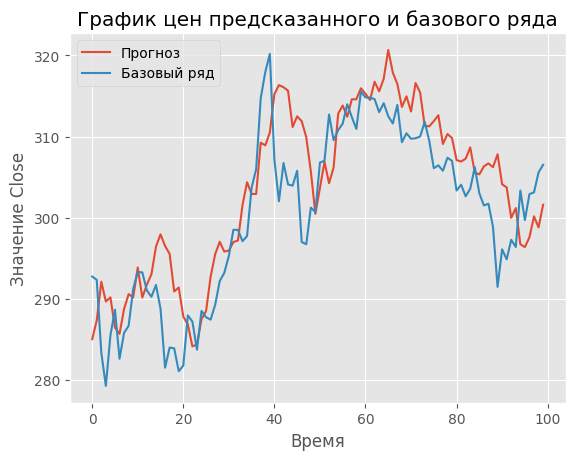

In [ ]:
#Отображаем график распределения прогнозируемого и базового ряда на коротком промежутке для наглядности точности предсказания
showPredict(100, 100, 0, predVal, yValUnscaled)

## Сеть с долгой краткосрочной памятью LSTM

В этой сети используется тот же датасет, что и в сверточной сети, так что формируем модель сети

In [ ]:
def lstm55(xTrain, yTrain):
  from keras.layers import Input, Dense
  from sklearn.metrics import jaccard_score
  from sklearn.metrics import log_loss
  from keras.layers import BatchNormalization  #InstanceNorm
  import tensorflow as tf

  from tensorflow.keras import regularizers

  from keras.models import Model
  xtr0 = xTrain.shape[0]
  xtr1 = xTrain.shape[1]
  xtr2 = xTrain.shape[2]

  inputss = Input(shape = (xtr1, xtr2))
  lstm1 = LSTM(units = 128, return_sequences = True)(inputss)
  lstm2 = LSTM(units = 128,  return_sequences = True)(lstm1)
  lstm3 = LSTM(units = 128,)(lstm2)
  dense1 = Dense(128, activation = "linear")(lstm3)
  output = Dense(yTrain.shape[1], activation="linear")(dense1)
  modellstm = Model(inputs = inputss, outputs=output)

  modellstm.compile(loss = "huber_loss", optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4))
  history = modellstm.fit(xTrain, yTrain, validation_data=(xVal, yVal), epochs = 50, batch_size = 32, verbose = 1)

  # Выводим график изменения ошибок
  plt.plot(history.history['loss'],
           label='Средняя абсолютная ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'],
           label='Средняя абсолютная ошибка на проверочном наборе')
  plt.ylabel('Средняя ошибка')
  plt.legend()
  plt.show()
  return (history, modellstm)



Epoch 1/50
73/73 [==============================] - 32s 351ms/step - loss: 0.0099 - val_loss: 0.0277
Epoch 2/50
73/73 [==============================] - 25s 345ms/step - loss: 0.0024 - val_loss: 0.0098
Epoch 3/50
73/73 [==============================] - 23s 312ms/step - loss: 0.0018 - val_loss: 0.0097
Epoch 4/50
73/73 [==============================] - 26s 354ms/step - loss: 0.0017 - val_loss: 0.0146
Epoch 5/50
73/73 [==============================] - 26s 355ms/step - loss: 0.0015 - val_loss: 0.0120
Epoch 6/50
73/73 [==============================] - 23s 312ms/step - loss: 0.0015 - val_loss: 0.0090
Epoch 7/50
73/73 [==============================] - 26s 353ms/step - loss: 0.0014 - val_loss: 0.0129
Epoch 8/50
73/73 [==============================] - 26s 359ms/step - loss: 0.0014 - val_loss: 0.0080
Epoch 9/50
73/73 [==============================] - 24s 326ms/step - loss: 0.0014 - val_loss: 0.0094
Epoch 10/50
73/73 [==============================] - 24s 330ms/step - loss: 0.0013 - val_lo

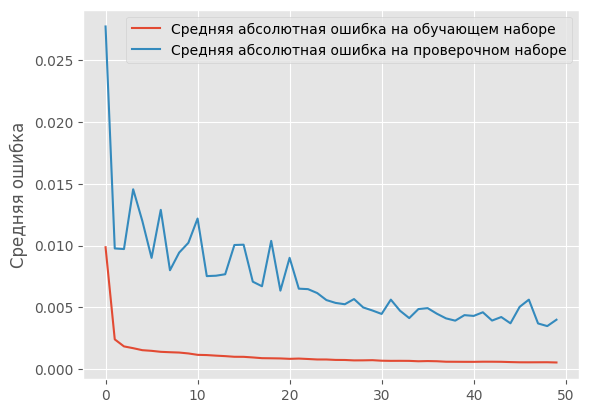

In [ ]:
# Запуск обучения
(historyC, modelC) = lstm55(xTrain, yTrain)

23/23 [==============================] - 5s 199ms/step


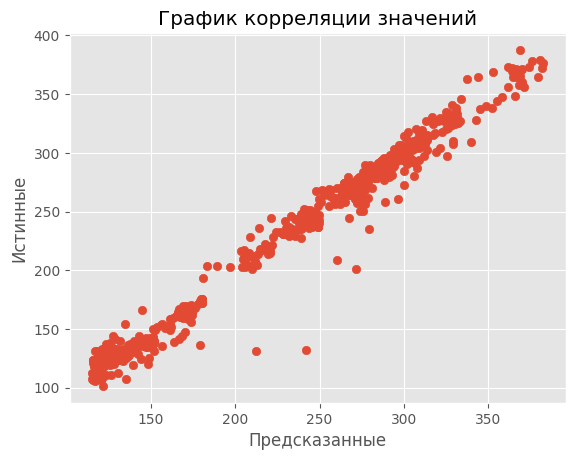

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xTest, yTest, yScaler)

# график корреляции истинных и предсказанных значений
import matplotlib
matplotlib.style.use('ggplot')
plt.scatter(predVal, yValUnscaled)
plt.title("График корреляции значений")
plt.xlabel("Предсказанные")
plt.ylabel("Истинные")
plt.show()

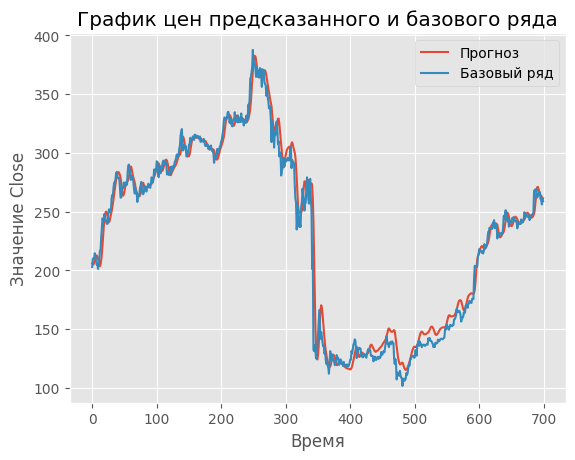

In [ ]:
#Отображаем график распределения прогнозируемого и базового ряда
# задаем начало и интервал отображения графика
showPredict(0, 700, 0, predVal, yValUnscaled)

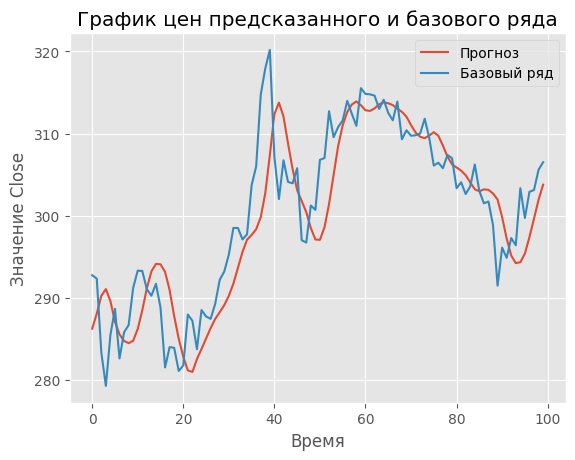

In [ ]:
#Отображаем график распределения прогнозируемого и базового ряда на коротком промежутке для наглядности точности предсказания
showPredict(100, 100, 0, predVal, yValUnscaled)

## Вывод:
Мы рассмотрели 4 вида модели для предсказания временного ряда:
- ARIMA - не смог выявить тренд, сезонность и волатильность.
- SARIMAX - выявлена некоторая дисперсия движения цен акций, но не смогла определить амплитуду движений.
- CONV1D - хорошо предсказывает движение цены на определенное количество шагов, в данном случае один шаг. Быстро учится. Больше реагирует на колебание цен. Можно улучшить результат более сложными и мощными моделями.
- LSTM - Прогноз цен более точен чем другие модели. Требуется больше времени на обучение. Игнорирует выбросы цен во временном ряду. График гладкий, без колебаний. Можно улучшить результат более сложными моделями.
Для улучшения точности можно также добавить признаки, другими показателями популярных трендовых или индикаторных линий, характеризующими график цен.